In [53]:
from openpyxl import load_workbook
from pathlib import Path

In [54]:
home = Path.cwd()
path = home/'Sample Data.xlsx'

In [55]:
my_excel_file = Path.home() / home/'Sample Data.xlsx'
wb = load_workbook(my_excel_file)
ws = wb.worksheets[0]

In [56]:
sample_name = ws['a2'].value
width = ws['b2'].value
thickness = ws['c2'].value

In [62]:
def coupon_test (thickness: float = 2.5, 
                 width: float = 10, 
                 file_name: str = 'testdata.csv',
                 lower_bound: float = 0.1, 
                 upper_bound: float = 0.3):
    """
    Post-process a tensile coupon test and plot stress-strain curve.
    
    Args:
        Thickness (float): Specimen thickness in mm.
        Width (float): Specimen width in mm.
        file_name (str): CSV file containing test data.
        low_bound (float): Lower bound of elastic region as fraction of UTS.
        upper_bound (float): Upper bound of elastic region as fraction of UTS.
        save_path (str, optional): Path to save the figure. If None, do not save.

    Returns:
        fig (matplotlib.figure.Figure): Figure object containing the plot.
    """
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    %matplotlib widget
    # Constants
    thickness # mm
    width # mm
    area = thickness * width  # Calculate the area of the specimen
    
    # Load tensile test data
    df = pd.read_csv(file_name, header=[0])
    
    #df.columns = [f"{col[0]} {col[1]}" for col in df.columns]
    
    # Extract relevant columns
    #time = df["Time (sec)"]
    #displacement = df["Crosshead separation (mm)"]
    force = df[df.columns[1]]
    elongation = df[df.columns[2]]
    strain = elongation # Strain in mm/mm
    
    # Calculate stress and strain
    force = force * 1000 # Convert kN to N
    stress = (force / area)  # N/m^2 or Pa
    uts = stress.max()
    
    #find the data before uts
    idx_peak = np.argmax(stress)
    strain_up = strain[:idx_peak+1]
    stress_up = stress[:idx_peak+1]
    
    #Boundary for 20% - 50% of UTS
    lower_bound = 0.1 * uts
    upper_bound = 0.3 * uts
    
    elastic_reg = (lower_bound <= stress_up) & (stress_up <= upper_bound)
    
    stress_ela = stress_up[elastic_reg]
    strain_ela = strain_up[elastic_reg] 
    
    E, intercept = np.polyfit(strain_ela, stress_ela, 1)
    #print(f"Young's Modulus is: {E} MPa",)
    E_GPa = E / 1000  # Convert MPa to GPa
    #print(f"Intercept: {intercept} MPa")
   
    # Select over 30% of UTS, as yield stress will over 30% uts
    strain_new = elongation
    stress_new = force / area
    mask = (lower_bound <= stress)
    strain_mask = strain_new[mask]
    stress_mask = stress_new[mask]
    
    offset_decimal = 0.002  # 0.2% in decimal
    offset_line = E * (strain_new - offset_decimal) + intercept

    #Find the Yield strength
    diff = stress_mask - offset_line
    cross_index = np.where(diff <= 0)[0][0] 
    x1 = strain_mask[cross_index-1]
    x2 = strain_mask[cross_index]
    y1 = diff[cross_index-1]
    y2 = diff[cross_index]
    yield_strain = x1 - y1 * (x2 - x1) / (y2 - y1)
    yield_strength = np.interp(yield_strain, strain_new, stress_new)

    #Plot
    fig, ax = plt.subplots(figsize=(10,6))
    
    ax.plot(strain, stress, label='Stress-Strain Curve', color='blue')
    ax.plot(strain_new, offset_line, label='0.2% Offset Strain Line', color='yellow',linestyle = '--')
    

    
    ax.axhline(y=yield_strength, label=f'Yield Strength = {yield_strength:.2f} MPa', color='green', linestyle = '--')
    ax.axhline(y=uts, color='red', linestyle = '--', label=f'UTS = {uts:.2f} MPa')
    ax.plot(yield_strain, yield_strength, 'ro', label='Yield Point')
    
    ax.set_xlabel('Strain (mm/mm)')
    ax.set_ylabel('Stress (MPa)')
    ax.set_title('Stress-Strain Curve with Mechanical Properties')
    ax.legend()
    ax.grid(True)
    ax.set_ylim(0, 500)
    plt.show()
    # Print results
    print(f"Young's Modulus (E): {E_GPa:.2f} GPa")
    print(f"Ultimate Tensile Strength (UTS): {uts:.2f} MPa")
    print(f"Yield Strength: {yield_strength:.2f} MPa")

    
    # Prepare results dictionary
    results = {
        "E_GPa": E_GPa,
        "UTS_MPa": uts,
        "Yield_Strength_MPa": yield_strength
    }
    #results = [E_GPa, uts, yield_strength]
    return file_name[:-4], fig, results

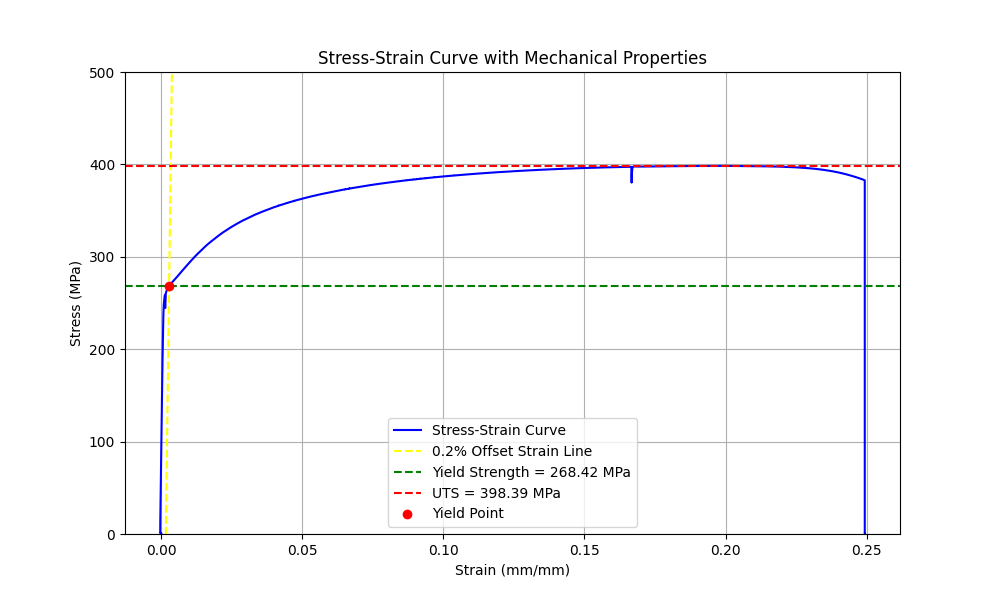

Young's Modulus (E): 232.08 GPa
Ultimate Tensile Strength (UTS): 398.39 MPa
Yield Strength: 268.42 MPa


In [63]:
C = coupon_test(thickness=thickness, width=width, file_name='C-2DPS-2.csv')

In [64]:
C[2]

{'E_GPa': np.float64(232.08231183965586),
 'UTS_MPa': np.float64(398.39423719999996),
 'Yield_Strength_MPa': np.float64(268.42295107315533)}

In [67]:
for col, value in enumerate(C[2].values(), start=4):
    ws.cell(row=2, column=col, value=float(value))
wb.save(path)  # 覆盖保存